In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [32]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('../data/train_processed.csv')
train_selected = pd.read_csv('../data/train_selected.csv')

In [33]:
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [34]:
X_train = train.drop(columns=["Target",'idhogar'])
X_selected = train_selected.drop(columns=["Target",'idhogar'])
y_train = train['Target']

In [35]:
rf = RandomForestClassifier(n_estimators = 100, random_state=10, n_jobs = 3)

In [36]:
cv_scores = cross_val_score(rf, X_train, y_train, cv = 10, scoring=scorer, n_jobs = -1)
print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')

10 Fold CV Score: 0.34386 with std: 0.03134


In [37]:
cv_scores = cross_val_score(rf, X_selected, y_train, cv = 10, scoring=scorer, n_jobs = -1)
print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')

10 Fold CV Score: 0.36297 with std: 0.04079


In [38]:
train.shape

(2973, 228)

In [39]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

## Confusion matrix

In [40]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

## Investigation of the confusion matrix
* 1 = extreme poverty 
* 2 = moderate poverty 
* 3 = vulnerable households 
* 4 = non vulnerable households

Confusion matrix, without normalization
[[ 11  13   2  32]
 [  3  35   2  76]
 [  2   8   5  75]
 [  4  13   3 460]]


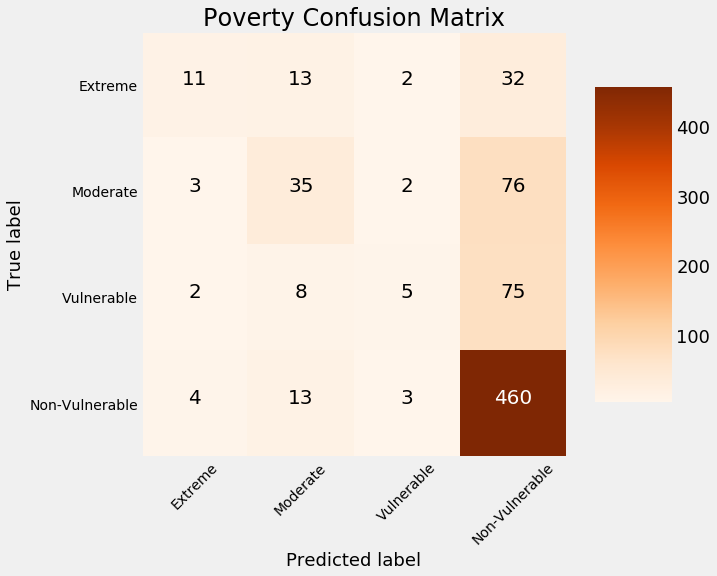

In [41]:
p_train, p_test, l_train, l_test = train_test_split(X_train, y_train, random_state=42)
rf.fit(p_train, l_train)
pred = rf.predict(p_test)
cm = confusion_matrix(l_test, pred)

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

In [42]:
test_results = pd.DataFrame(data=l_test)
test_results['Predicted'] = pred

In [43]:
def get_indexes(test_results, true_label, pred_label):
    return test_results[(test_results['Target']==true_label) & (test_results['Predicted']==pred_label)].index

def get_cofused_entries(df, test_results, true_label, pred_label):
    return df.loc[get_indexes(test_results, true_label, pred_label)]

In [44]:
nonvul_as_moderate = get_cofused_entries(p_test, test_results, 4, 2)
moderate_as_nonvul = get_cofused_entries(p_test, test_results, 2, 4)

In [45]:
import shap
from IPython.display import display, HTML

shap.initjs()

def plot_influence_on_pred(df, shap_values, expected_value, index):
    display(HTML("<h1>What influenced prediction for {}th sample</h1>".format(index+1)))
    display(HTML("<h2>Prediction of class 4 (Non-vulnerable) probability"))
    display(shap.force_plot(expected_value[3], shap_values[3][index], df.iloc[index,:]))
    display(HTML("<h2>Prediction of class 3 (Vulnerable) probability"))
    display(shap.force_plot(expected_value[2], shap_values[2][index], df.iloc[index,:]))
    display(HTML("<h2>Prediction of class 2 (Moderate vulnerability) probability"))
    display(shap.force_plot(expected_value[1], shap_values[1][index], df.iloc[index,:]))
    display(HTML("<h2>Prediction of class 1 (Extreme vulnerability) probability"))
    display(shap.force_plot(expected_value[0], shap_values[0][index], df.iloc[index,:]))

In [46]:
explainer = shap.TreeExplainer(rf)

## Analizing True Non-vulnerable predicted as False Moderate

In [47]:
shap_values = explainer.shap_values(nonvul_as_moderate)
expected_value = explainer.expected_value

In [48]:
rf.predict_proba(nonvul_as_moderate)

array([[0.07, 0.36, 0.22, 0.35],
       [0.11, 0.47, 0.21, 0.21],
       [0.12, 0.34, 0.25, 0.29],
       [0.12, 0.42, 0.15, 0.31],
       [0.34, 0.37, 0.11, 0.18],
       [0.09, 0.51, 0.17, 0.23],
       [0.19, 0.43, 0.14, 0.24],
       [0.19, 0.37, 0.1 , 0.34],
       [0.08, 0.35, 0.24, 0.33],
       [0.04, 0.48, 0.25, 0.23],
       [0.26, 0.38, 0.23, 0.13],
       [0.27, 0.38, 0.08, 0.27],
       [0.11, 0.36, 0.25, 0.28]])

In [49]:
def plot_influence_on_pred_moderate(df, shap_values, expected_value, index):
    display(HTML("<h2>Prediction of class 2 (Moderate vulnerability) probability for observation {}".format(index)))
    display(shap.force_plot(expected_value[1], shap_values[1][index], df.iloc[index,:]))

In [50]:
for sample_id in nonvul_as_moderate.index.values:
    index = nonvul_as_moderate.index.get_loc(sample_id)
    plot_influence_on_pred_moderate(nonvul_as_moderate, shap_values, expected_value, index)

We can see that the features that in the most cases contribute to the false Moderate prediction are:
1) dependency (8 times in top 3)
2) escolari-min (11 times in top 7)
3) meaneduc (7 times in top 4)
4) walls+roof+floor (8 times in top 8)
5) phones-per-capita (5 tomes in top 4)
6) escolari-max (5 times in top 7)
7) eviv1 (6 times in top 6)

In [51]:
shap.force_plot(expected_value[1], shap_values[1], nonvul_as_moderate)

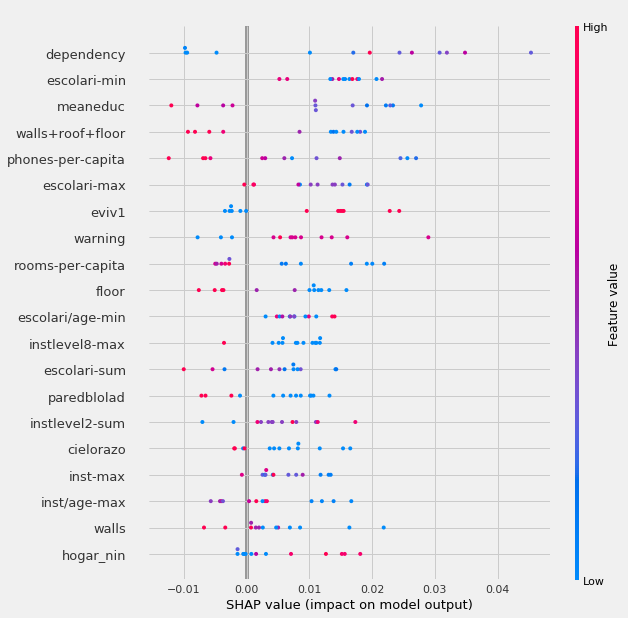

In [52]:
shap.summary_plot(shap_values[1], nonvul_as_moderate)

False Moderate prediction in the case are explained by high dependency, low escolari-min, low meaneduc, walls+roof+floor, low phone-per-capita, low escolari-max, high eviv1, high warning, low rooms-per-capita, low floor, high escolari/age-min, low instlevel8-max

### Experiment: changing the feature values

In [53]:
def test_change_in_ordinal_class_pred(model, df, class_true, feature_name, change_rate):
    df_experiment = df.copy()
    orig_class_pred = model.predict(df)
    orig_class_points = -1*abs(orig_class_pred - class_true)
    orig_class_points_sum = sum(orig_class_points)
    orig_class_diff_abs = abs(class_true - orig_class_pred)
    for change_index in range(1, 11):
        change = 1 + change_index*change_rate
        df_experiment[feature_name] = df[feature_name]*change
        class_pred = model.predict(df_experiment)
        class_diff_abs = abs(class_true - class_pred)
        class_points = -1*class_diff_abs
        class_points_sum = sum(class_points)
        class_change_pos = sum(class_diff_abs < orig_class_diff_abs)
        class_change_neg = sum(class_diff_abs > orig_class_diff_abs)
        class_points_change = class_points_sum - orig_class_points_sum
        print("{:.2f}% {} change: {} class points improvement, {} towards true, {} away true".format
              (change_index*change_rate*100, feature_name, class_points_change, class_change_pos, 
               class_change_neg))

In [54]:
test_change_in_ordinal_class_pred(rf, nonvul_as_moderate, 
                                  np.full((nonvul_as_moderate.shape[0]), 4), "dependency", -.1)

-10.00% dependency change: 2.0 class points improvement, 1 towards true, 0 away true
-20.00% dependency change: 2.0 class points improvement, 1 towards true, 0 away true
-30.00% dependency change: 4.0 class points improvement, 2 towards true, 0 away true
-40.00% dependency change: 4.0 class points improvement, 2 towards true, 0 away true
-50.00% dependency change: 4.0 class points improvement, 2 towards true, 0 away true
-60.00% dependency change: 6.0 class points improvement, 3 towards true, 0 away true
-70.00% dependency change: 8.0 class points improvement, 4 towards true, 0 away true
-80.00% dependency change: 8.0 class points improvement, 4 towards true, 0 away true
-90.00% dependency change: 8.0 class points improvement, 4 towards true, 0 away true
-100.00% dependency change: 8.0 class points improvement, 4 towards true, 0 away true


In [55]:
test_change_in_ordinal_class_pred(rf, nonvul_as_moderate, 
                                  np.full((nonvul_as_moderate.shape[0]), 4), "escolari-min", .1)

10.00% escolari-min change: 2.0 class points improvement, 1 towards true, 0 away true
20.00% escolari-min change: 2.0 class points improvement, 1 towards true, 0 away true
30.00% escolari-min change: 2.0 class points improvement, 1 towards true, 0 away true
40.00% escolari-min change: 2.0 class points improvement, 1 towards true, 0 away true
50.00% escolari-min change: 2.0 class points improvement, 1 towards true, 0 away true
60.00% escolari-min change: 2.0 class points improvement, 1 towards true, 0 away true
70.00% escolari-min change: 2.0 class points improvement, 1 towards true, 0 away true
80.00% escolari-min change: 2.0 class points improvement, 1 towards true, 0 away true
90.00% escolari-min change: 4.0 class points improvement, 2 towards true, 0 away true
100.00% escolari-min change: 4.0 class points improvement, 2 towards true, 0 away true


In [56]:
test_change_in_ordinal_class_pred(rf, nonvul_as_moderate, 
                                  np.full((nonvul_as_moderate.shape[0]), 4), "escolari-max", .1)

10.00% escolari-max change: 4.0 class points improvement, 2 towards true, 0 away true
20.00% escolari-max change: 6.0 class points improvement, 3 towards true, 0 away true
30.00% escolari-max change: 6.0 class points improvement, 3 towards true, 0 away true
40.00% escolari-max change: 5.0 class points improvement, 3 towards true, 1 away true
50.00% escolari-max change: 6.0 class points improvement, 3 towards true, 0 away true
60.00% escolari-max change: 5.0 class points improvement, 3 towards true, 1 away true
70.00% escolari-max change: 5.0 class points improvement, 3 towards true, 1 away true
80.00% escolari-max change: 5.0 class points improvement, 3 towards true, 1 away true
90.00% escolari-max change: 5.0 class points improvement, 3 towards true, 1 away true
100.00% escolari-max change: 5.0 class points improvement, 3 towards true, 1 away true


In [57]:
test_change_in_ordinal_class_pred(rf, nonvul_as_moderate, 
                                  np.full((nonvul_as_moderate.shape[0]), 4), "meaneduc", .1)

10.00% meaneduc change: 2.0 class points improvement, 1 towards true, 0 away true
20.00% meaneduc change: 2.0 class points improvement, 1 towards true, 0 away true
30.00% meaneduc change: 4.0 class points improvement, 2 towards true, 0 away true
40.00% meaneduc change: 4.0 class points improvement, 2 towards true, 0 away true
50.00% meaneduc change: 4.0 class points improvement, 2 towards true, 0 away true
60.00% meaneduc change: 4.0 class points improvement, 2 towards true, 0 away true
70.00% meaneduc change: 4.0 class points improvement, 2 towards true, 0 away true
80.00% meaneduc change: 4.0 class points improvement, 2 towards true, 0 away true
90.00% meaneduc change: 4.0 class points improvement, 2 towards true, 0 away true
100.00% meaneduc change: 4.0 class points improvement, 2 towards true, 0 away true


In case of observation # 5 the increase of escolari-max starting from 40% causes the even worse misclassification as false Extreme poor - which seems to be the example of biased ML application

In [58]:
nonvul_as_moderate_exp = nonvul_as_moderate.copy()
nonvul_as_moderate_exp["escolari-max"] = nonvul_as_moderate_exp["escolari-max"]*1.4
rf.predict(nonvul_as_moderate_exp)

array([4., 2., 4., 2., 1., 2., 2., 2., 4., 2., 2., 2., 2.])

## Analizing True Moderate predicted as False Non-vulnerable

In [59]:
shap_values = explainer.shap_values(moderate_as_nonvul)
expected_value = explainer.expected_value

In [60]:
rf.predict_proba(moderate_as_nonvul)

array([[0.18, 0.2 , 0.24, 0.38],
       [0.05, 0.18, 0.21, 0.56],
       [0.05, 0.13, 0.15, 0.67],
       [0.04, 0.09, 0.1 , 0.77],
       [0.09, 0.34, 0.21, 0.36],
       [0.1 , 0.26, 0.24, 0.4 ],
       [0.18, 0.2 , 0.23, 0.39],
       [0.03, 0.  , 0.06, 0.91],
       [0.13, 0.31, 0.24, 0.32],
       [0.21, 0.26, 0.17, 0.36],
       [0.01, 0.15, 0.28, 0.56],
       [0.08, 0.09, 0.24, 0.59],
       [0.02, 0.05, 0.11, 0.82],
       [0.19, 0.21, 0.2 , 0.4 ],
       [0.04, 0.25, 0.25, 0.46],
       [0.02, 0.21, 0.08, 0.69],
       [0.05, 0.28, 0.11, 0.56],
       [0.18, 0.18, 0.1 , 0.54],
       [0.08, 0.24, 0.08, 0.6 ],
       [0.03, 0.29, 0.2 , 0.48],
       [0.25, 0.12, 0.18, 0.45],
       [0.16, 0.3 , 0.22, 0.32],
       [0.08, 0.13, 0.08, 0.71],
       [0.09, 0.26, 0.15, 0.5 ],
       [0.  , 0.04, 0.06, 0.9 ],
       [0.14, 0.12, 0.21, 0.53],
       [0.03, 0.23, 0.12, 0.62],
       [0.06, 0.1 , 0.19, 0.65],
       [0.16, 0.23, 0.2 , 0.41],
       [0.17, 0.3 , 0.16, 0.37],
       [0.

In [61]:
def plot_influence_on_pred_nonvulnerable(df, shap_values, expected_value, index):
    display(HTML("<h2>Prediction of class 4 (Non-vulnerable vulnerability) probability for observation {}".format(index)))
    display(shap.force_plot(expected_value[3], shap_values[3][index], df.iloc[index,:]))

In [62]:
for sample_id in moderate_as_nonvul.sample(20, random_state=42).index.values:
        index = moderate_as_nonvul.index.get_loc(sample_id)
        plot_influence_on_pred_nonvulnerable(moderate_as_nonvul, shap_values, expected_value, index)   

In [63]:
shap.force_plot(expected_value[3], shap_values[3], moderate_as_nonvul)

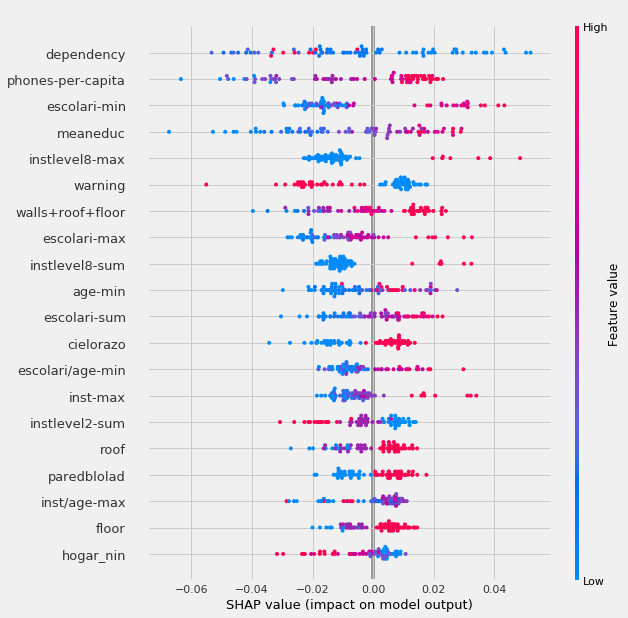

In [64]:
shap.summary_plot(shap_values[3], moderate_as_nonvul)

False Non-vulnerable prediction in the case are explained by low dependency, high phones-per-capita, high escolari-min, hight meaneduc, high instlevel8-max, low warning, high walls+roof+floor, high escolari-max, high instlevel8-sum, high escolari-sum, high cielorazo, high escolari/age-min, high inst-max, low intslevel2-sum

### Experiment: changing the feature values

In [65]:
test_change_in_ordinal_class_pred(rf, moderate_as_nonvul, 
                                  np.full((moderate_as_nonvul.shape[0]), 2), "dependency", .1)

10.00% dependency change: 6.0 class points improvement, 3 towards true, 0 away true
20.00% dependency change: 6.0 class points improvement, 3 towards true, 0 away true
30.00% dependency change: 8.0 class points improvement, 4 towards true, 0 away true
40.00% dependency change: 8.0 class points improvement, 4 towards true, 0 away true
50.00% dependency change: 9.0 class points improvement, 5 towards true, 0 away true
60.00% dependency change: 9.0 class points improvement, 5 towards true, 0 away true
70.00% dependency change: 13.0 class points improvement, 7 towards true, 0 away true
80.00% dependency change: 13.0 class points improvement, 7 towards true, 0 away true
90.00% dependency change: 13.0 class points improvement, 7 towards true, 0 away true
100.00% dependency change: 13.0 class points improvement, 7 towards true, 0 away true


In [66]:
test_change_in_ordinal_class_pred(rf, moderate_as_nonvul, 
                                  np.full((moderate_as_nonvul.shape[0]), 2), "phones-per-capita", -.1)

-10.00% phones-per-capita change: 0.0 class points improvement, 0 towards true, 0 away true
-20.00% phones-per-capita change: 2.0 class points improvement, 1 towards true, 0 away true
-30.00% phones-per-capita change: 17.0 class points improvement, 9 towards true, 0 away true
-40.00% phones-per-capita change: 11.0 class points improvement, 6 towards true, 0 away true
-50.00% phones-per-capita change: 16.0 class points improvement, 9 towards true, 0 away true
-60.00% phones-per-capita change: 20.0 class points improvement, 11 towards true, 0 away true
-70.00% phones-per-capita change: 18.0 class points improvement, 10 towards true, 0 away true
-80.00% phones-per-capita change: 16.0 class points improvement, 9 towards true, 0 away true
-90.00% phones-per-capita change: 16.0 class points improvement, 9 towards true, 0 away true
-100.00% phones-per-capita change: 16.0 class points improvement, 9 towards true, 0 away true


In [67]:
test_change_in_ordinal_class_pred(rf, moderate_as_nonvul, 
                                  np.full((moderate_as_nonvul.shape[0]), 2), "escolari-min", -.1)

-10.00% escolari-min change: 1.0 class points improvement, 1 towards true, 0 away true
-20.00% escolari-min change: 0.0 class points improvement, 0 towards true, 0 away true
-30.00% escolari-min change: 1.0 class points improvement, 1 towards true, 0 away true
-40.00% escolari-min change: 1.0 class points improvement, 1 towards true, 0 away true
-50.00% escolari-min change: 4.0 class points improvement, 3 towards true, 0 away true
-60.00% escolari-min change: 4.0 class points improvement, 3 towards true, 0 away true
-70.00% escolari-min change: 4.0 class points improvement, 3 towards true, 0 away true
-80.00% escolari-min change: 4.0 class points improvement, 3 towards true, 0 away true
-90.00% escolari-min change: 4.0 class points improvement, 3 towards true, 0 away true
-100.00% escolari-min change: 4.0 class points improvement, 3 towards true, 0 away true


In [68]:
test_change_in_ordinal_class_pred(rf, moderate_as_nonvul, 
                                  np.full((moderate_as_nonvul.shape[0]), 2), "meaneduc", -.1)

-10.00% meaneduc change: 0.0 class points improvement, 0 towards true, 0 away true
-20.00% meaneduc change: 2.0 class points improvement, 1 towards true, 0 away true
-30.00% meaneduc change: 4.0 class points improvement, 2 towards true, 0 away true
-40.00% meaneduc change: 4.0 class points improvement, 2 towards true, 0 away true
-50.00% meaneduc change: 6.0 class points improvement, 3 towards true, 0 away true
-60.00% meaneduc change: 4.0 class points improvement, 2 towards true, 0 away true
-70.00% meaneduc change: 4.0 class points improvement, 2 towards true, 0 away true
-80.00% meaneduc change: 5.0 class points improvement, 3 towards true, 0 away true
-90.00% meaneduc change: 5.0 class points improvement, 3 towards true, 0 away true
-100.00% meaneduc change: 5.0 class points improvement, 3 towards true, 0 away true
